In [68]:
import pandas as pd
import numpy as np
import itertools

from sklearn.model_selection import StratifiedKFold, KFold

from matplotlib import pyplot as plt

%matplotlib inline

In [3]:
label_df = pd.read_csv("./data/labels.csv", index_col="sample_id")
# remove samples without any label
label_df = label_df[~label_df.isnull().all(axis=1)].reset_index()

---------label_gender-----------


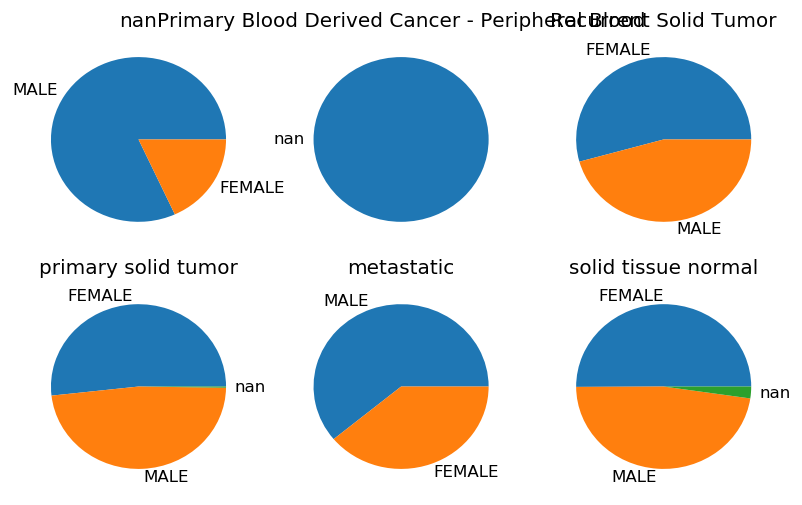

---------label_tissue-----------


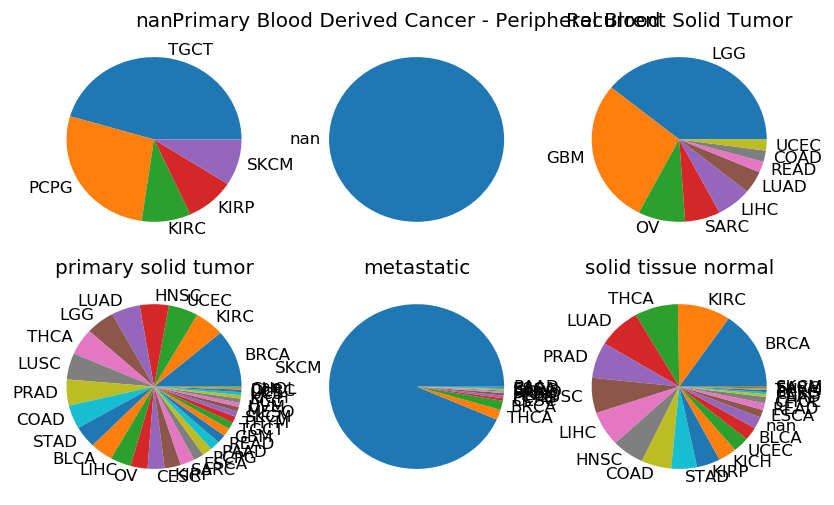

In [29]:
for pie_chart_label in ["label_gender", "label_tissue"]:
    fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(8,5), dpi=120)
    print("---------{0}-----------".format(pie_chart_label))
    for i, tumor_type in enumerate(list(set(label_df.label_tumor))):
        row = i // 3
        col = i % 3
        if tumor_type is np.nan:
            this_tumor = label_df[pd.isnull(label_df.label_tumor)].copy()
        else:
            this_tumor = label_df[label_df.label_tumor==tumor_type].copy()
        ax = this_tumor[pie_chart_label].value_counts(normalize=True, dropna=False).plot.pie(ax=axes[row][col])
        axes[row][col].set_ylabel("")
        axes[row][col].set_title(tumor_type)
    plt.show()

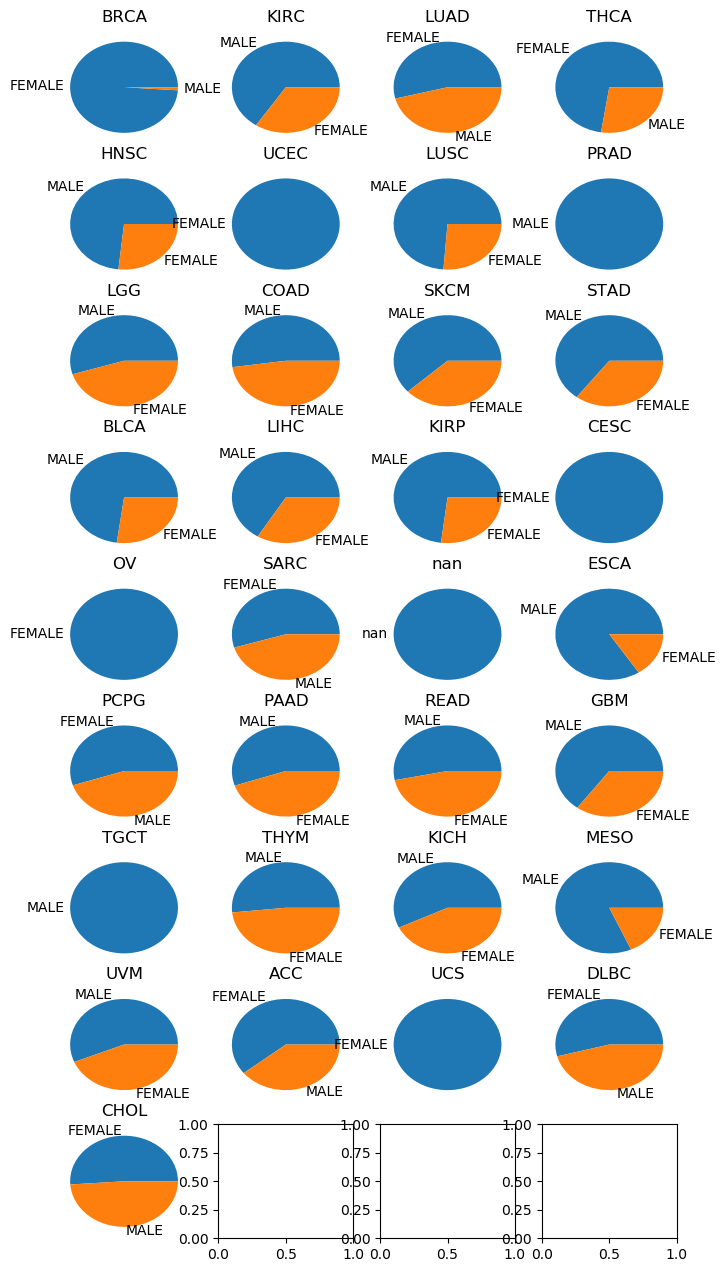

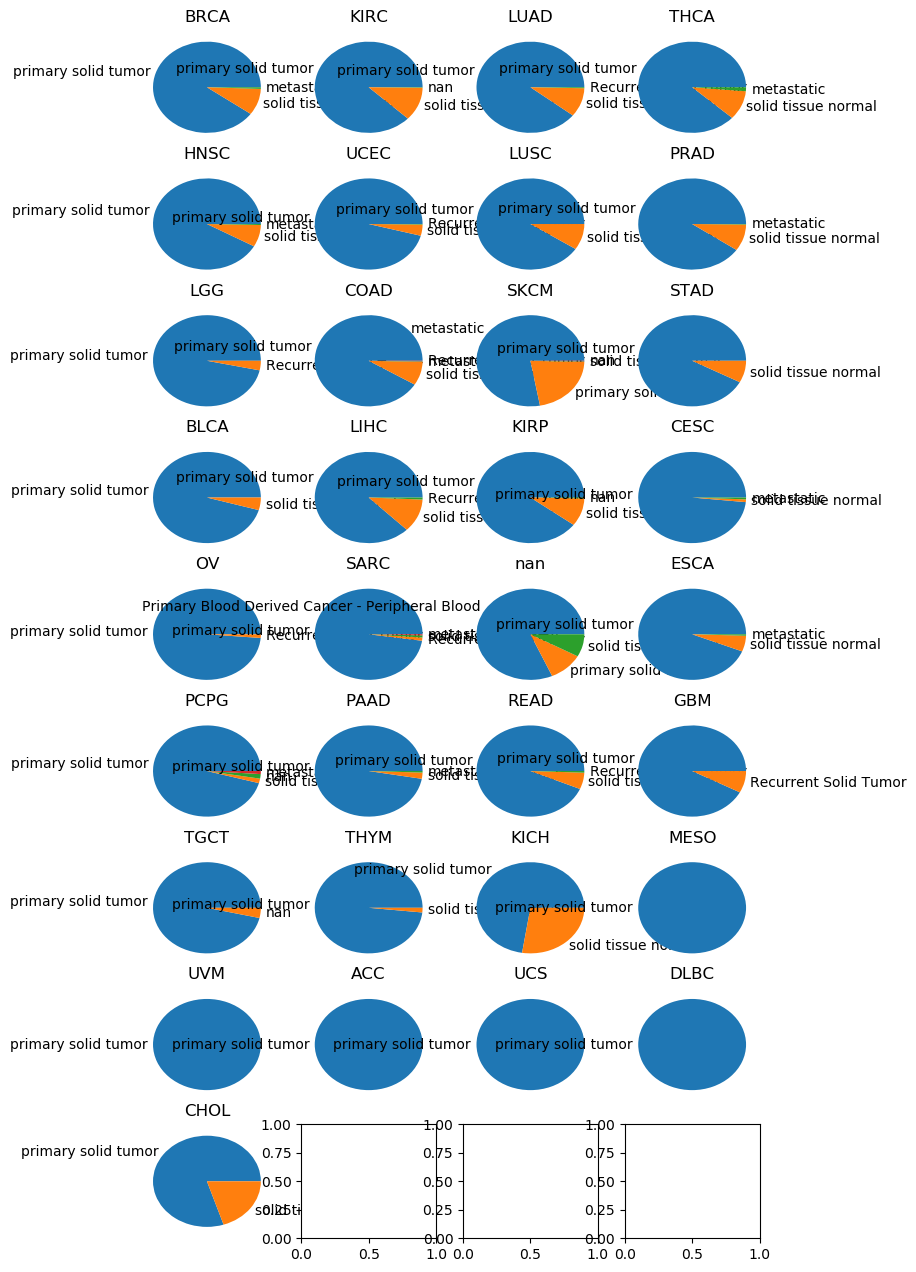

In [30]:
for pie_chart_label in ["label_gender", "label_tumor"]:
    fig, axes = plt.subplots(ncols=4, nrows=9, figsize=(8, 16), dpi=100)
    for i, tissue_type in enumerate(label_df.label_tissue.value_counts(dropna=False).index):
        row = i // 4
        col = i % 4
        if tissue_type is np.nan:
            this_tissue = label_df[pd.isnull(label_df.label_tissue)].copy()
        else:
            this_tissue = label_df[label_df.label_tissue==tissue_type].copy()
        this_tissue[pie_chart_label].value_counts(normalize=True, dropna=False).plot.pie(ax=axes[row][col])
        axes[row][col].set_ylabel("")
        axes[row][col].set_title(tissue_type)
    plt.show()

### get the number of samples in each one of the tumor \* tissue \* gender combination (4 \* 32 \* 2 = 256)

In [147]:
multi_label_count = label_df.groupby(["label_tumor", "label_tissue", "label_gender"]).count()

In [148]:
multi_label_count

sample_id
label_tumor           label_tissue label_gender           
Recurrent Solid Tumor COAD         FEMALE                1
                      GBM          FEMALE                5
                                   MALE                  8
                      LGG          FEMALE               11
                                   MALE                  7
                      LIHC         MALE                  3
                      LUAD         MALE                  2
                      OV           FEMALE                4
                      READ         MALE                  1
                      SARC         FEMALE                3
                      UCEC         FEMALE                1
metastatic            BRCA         FEMALE                7
                      CESC         FEMALE                2
                      COAD         FEMALE                1
                      ESCA         MALE                  1
                      HNSC         FEMALE                1
                                   MALE                  1
                      PAAD         MALE                  1
                      PCPG         MALE                  2
                      PRAD         MALE                  1
                      SARC         MALE                  1
                      SKCM         FEMALE              139
                                   MALE                230
                      THCA         FEMALE                4
                                   MALE                  4
primary solid tumor   ACC          FEMALE               48
                                   MALE                 31
                      BLCA         FEMALE              107
                                   MALE                301
                      BRCA         FEMALE             1085
...                                                    ...
solid tissue normal   HNSC         FEMALE               14
                                   MALE                 30
                      KICH         FEMALE               12
                                   MALE                 13
                      KIRC         FEMALE               20
                                   MALE                 52
                      KIRP         FEMALE               10
                                   MALE                 22
                      LIHC         FEMALE               22
                                   MALE                 28
                      LUAD         FEMALE               34
                                   MALE                 25
                      LUSC         FEMALE               14
                                   MALE                 37
                      PAAD         FEMALE                2
                                   MALE                  2
                      PCPG         FEMALE                1
                                   MALE                  2
                      PRAD         MALE                 52
                      READ         FEMALE                7
                                   MALE                  3
                      SARC         FEMALE                1
                                   MALE                  1
                      SKCM         MALE                  1
                      STAD         FEMALE               12
                                   MALE                 23
                      THCA         FEMALE               42
                                   MALE                 17
                      THYM         FEMALE                2
                      UCEC         FEMALE               22

[124 rows x 1 columns]

### Method:

#### 0. Prior to splitting:
* save samples that has Null as label in either gender, tissue or tumor type in a seperate dataframe (df_nulls)
* group rest of samples (those without nulls in any label) by same tumor type, tissue type and gender combination

#### 1. Train + validation vs test split:
* For groups that have >=20 samples, randomly take 5% to be included in the test set
* For groups that have < 20 but >=3 samples, take 1 sample to be included in the test set
* For groups that have < 3 samples, take None for the test set
* Add a random 5% from df_nulls to test set

#### 2. Train vs validation split:
* For groups with only 1 samples, always include that sample in training
* For groups with >2 but <5 samples, randomly pick one to put in validation, put the rest in training
* For groups combinations with >=5 samples, combined with df_nulls (with 5% test removed) split 5-fold for cross validation

In [149]:
def get_test_sample(count_df, label_df, df_nulls, random_seed=0):
    np.random.seed(random_seed)
    samples_chosen = []
    
    sample_groups1 = count_df[(count_df.sample_id>=3)&(count_df.sample_id<20)].index
    for group_idx in sample_groups1:
        samples_chosen.append(np.random.choice(list(label_df.loc[group_idx]["sample_id"])))
    
    sample_groups2 = count_df[count_df.sample_id>=20].index
    for idx in sample_groups2:
        this_group = list(label_df.loc[idx]["sample_id"])
        num_test_sample = int(len(this_group)/20)
        samples_chosen += list(np.random.choice(this_group, size=num_test_sample, replace=False))
    sample_group3 = np.random.choice(df_nulls.sample_id, size=int(df_nulls.shape[0]/20))
    samples_chosen += list(sample_group3)
    return samples_chosen

def save_sample_ids(filename, sample_ids):
    with open(filename, "w") as f:
        for i in sorted(sample_ids):
            f.write(i+"\n")
    print("file saved to", filename)

In [154]:
def get_train_val_special_case(count_df, label_df, random_seed=0):
    np.random.seed(random_seed)
    train_samples, val_samples = [], []
    train_samples += list(label_df.loc[count_df[count_df.sample_id==1].index]["sample_id"])
    
    sample_groups1 = count_df[(count_df.sample_id>1)&(count_df.sample_id<5)].index
    for group_idx in sample_groups1:
        this_group = list(label_df.loc[group_idx]["sample_id"])
        val_samples.append(np.random.choice(this_group))
        train_samples += [i for i in this_group if i not in val_samples]    
    return train_samples, val_samples
    
    
def stratfied_train_val_split(count_df, label_df, df_nulls, random_seed=0):
    df = label_df.loc[count_df[count_df.sample_id>=5].index]
    df = df.reset_index().set_index("sample_id")
    y = df.label_tumor + df.label_tissue + df.label_gender
    X = np.zeros(y.shape[0])
    kf = KFold(n_splits=5, shuffle=True, random_state=random_seed)
    y_nulls =  np.array(df_nulls.sample_id)
    y_nulls_split = [(y[i], y[j]) for (i, j) in list(kf.split(y_nulls))]

    fold_num = 0
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)
    for train_idx, val_idx in skf.split(X, y):
        train_sample_id = list(y.iloc[train_idx].index) + list(y_nulls_split[fold_num][0])
        val_sample_id = list(y.iloc[val_idx].index) + list(y_nulls_split[fold_num][1])
        fold_num += 1
        yield (train_sample_id, val_sample_id)

In [162]:
label_df = pd.read_csv("./data/labels.csv")
label_df = label_df[~label_df.isnull().all(axis=1)] # remove samples without any label
df_nulls = label_df[label_df.isnull().any(axis=1)]
df_no_nulls = label_df[~label_df.sample_id.isin(df_nulls.sample_id)]
df_no_nulls = df_no_nulls.set_index(["label_tumor", "label_tissue", "label_gender"]).sort_index()
count_df = df_no_nulls.groupby(level=[0,1,2]).count()

In [163]:
# get test
random_seed = 2
test_samples = get_test_sample(count_df, df_no_nulls, df_nulls, random_seed=random_seed)
test_df = label_df[label_df.sample_id.isin(test_samples)]

for label in ["label_tumor", "label_tissue", "label_gender"]:
    print(test_df[label].value_counts(normalize=True, dropna=False))

filename = "./data/train_val_test_split/seed{0}/test.csv".format(random_seed)
save_sample_ids(filename, test_samples)

primary solid tumor                                0.861940
solid tissue normal                                0.076493
metastatic                                         0.037313
Recurrent Solid Tumor                              0.013060
Primary Blood Derived Cancer - Peripheral Blood    0.011194
Name: label_tumor, dtype: float64
BRCA    0.113806
KIRC    0.054104
THCA    0.054104
UCEC    0.050373
HNSC    0.050373
LGG     0.050373
LUSC    0.048507
LUAD    0.048507
PRAD    0.048507
COAD    0.042910
BLCA    0.041045
SKCM    0.041045
STAD    0.041045
LIHC    0.039179
OV      0.029851
CESC    0.029851
KIRP    0.027985
SARC    0.024254
NaN     0.020522
ESCA    0.018657
READ    0.016791
GBM     0.016791
PCPG    0.014925
PAAD    0.014925
TGCT    0.011194
THYM    0.009328
KICH    0.007463
MESO    0.007463
CHOL    0.007463
UVM     0.005597
ACC     0.005597
UCS     0.003731
DLBC    0.003731
Name: label_tissue, dtype: float64
FEMALE    0.509328
MALE      0.470149
NaN       0.020522
Name: label_g

In [164]:
# get train, val 5 fold cv split
train_val_df = df_no_nulls[~df_no_nulls.sample_id.isin(test_samples)]
df_nulls_no_test = df_nulls[~df_nulls.sample_id.isin(test_samples)]
train_val_count = train_val_df.groupby(level=[0,1,2]).count()
train_samples_special, val_samples_special = get_train_val_special_case(
    train_val_count, train_val_df, random_seed=random_seed)
splitter = stratfied_train_val_split(train_val_count, train_val_df, 
                                     df_nulls_no_test, random_seed=random_seed)

for fold, (train_sample_id, val_sample_id) in enumerate(splitter):
    print("------------------fold {0}------------------".format(fold))
    train_sample_id += train_samples_special
    val_sample_id += val_samples_special
    val_df = label_df[label_df.sample_id.isin(val_sample_id)]
    for label in ["label_tumor", "label_tissue", "label_gender"]:
        print(val_df[label].value_counts(normalize=True, dropna=False))
    filename_train = "./data/train_val_test_split/seed{0}/train_fold{1}.csv".format(random_seed, fold) 
    filename_val = "./data/train_val_test_split/seed{0}/val_fold{1}.csv".format(random_seed, fold)
    save_sample_ids(filename_train, train_sample_id)
    save_sample_ids(filename_val, val_sample_id)

------------------fold 0------------------
primary solid tumor      0.886407
solid tissue normal      0.071768
metastatic               0.036597
Recurrent Solid Tumor    0.005228
Name: label_tumor, dtype: float64
BRCA    0.111217
KIRC    0.055133
LUAD    0.053232
THCA    0.052757
HNSC    0.051331
UCEC    0.050856
LUSC    0.050856
PRAD    0.049905
LGG     0.048954
COAD    0.045152
SKCM    0.043251
STAD    0.041350
BLCA    0.039449
LIHC    0.039449
KIRP    0.029943
CESC    0.028517
OV      0.028042
SARC    0.024240
ESCA    0.018061
PCPG    0.017586
PAAD    0.017586
GBM     0.016160
READ    0.016160
TGCT    0.012357
THYM    0.011407
KICH    0.009506
MESO    0.008080
UVM     0.007605
ACC     0.007605
UCS     0.005228
DLBC    0.004753
CHOL    0.004278
Name: label_tissue, dtype: float64
FEMALE    0.513308
MALE      0.486692
Name: label_gender, dtype: float64
file saved to ./data/train_val_test_split/seed2/train_fold0.csv
file saved to ./data/train_val_test_split/seed2/val_fold0.csv
---------